In [1]:
from scapy.all import rdpcap, IP, TCP, UDP
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import display, HTML, clear_output
import sys

In [2]:
# Konfigürasyon
PCAP_DIR = './'
OUTPUT_FILE = 'model_egitimi_hazir_veri.csv'
RESULTS_FILE = 'model_karsilastirma_sonuclari.csv'

In [3]:
# Global değişkenler
global_results = []
global_best_model = None
global_best_score = 0

# 1. Akış Anahtarı Oluşturma Fonksiyonu
def create_flow_key(packet):
    if 'IP' not in packet:
        return None
    
    ip_src = packet[IP].src
    ip_dst = packet[IP].dst
    
    if 'TCP' in packet:
        proto = 6
        port_src = packet[TCP].sport
        port_dst = packet[TCP].dport
    elif 'UDP' in packet:
        proto = 17
        port_src = packet[UDP].sport
        port_dst = packet[UDP].dport
    else:
        return None

    if ip_src > ip_dst:
        ip_src, ip_dst = ip_dst, ip_src
        port_src, port_dst = port_dst, port_src

    return (ip_src, ip_dst, port_src, port_dst, proto)

In [4]:
# 2. Akışları İşleme ve Özellik Çıkarma
def process_pcap_file(pcap_path, label):
    try:
        packets = rdpcap(pcap_path)
    except Exception as e:
        print(f"HATA: {pcap_path} dosyası okunamadı. {e}")
        return []

    flow_packets = {}
    
    for packet in packets:
        key = create_flow_key(packet)
        if key:
            if key not in flow_packets:
                flow_packets[key] = []
            
            packet_data = {
                'timestamp': float(packet.time),
                'size': int(len(packet)),
                'direction': 'fwd' if packet[IP].src == key[0] else 'bwd'
            }
            flow_packets[key].append(packet_data)

    flow_data_list = []
    
    for key, data in flow_packets.items():
        if len(data) < 2:
            continue
            
        times = [d['timestamp'] for d in data]
        sizes = [d['size'] for d in data]
        
        flow_duration = float(times[-1] - times[0])
        fwd_packets = int(sum(1 for d in data if d['direction'] == 'fwd'))
        bwd_packets = int(sum(1 for d in data if d['direction'] == 'bwd'))
        
        inter_arrival_times = [times[i+1] - times[i] for i in range(len(times)-1)]
        safe_duration = flow_duration if flow_duration > 0 else 0.001
        
        flow_data = {
            'label': label,
            'packet_count': int(len(data)),
            'flow_duration': float(safe_duration),
            'total_size': int(sum(sizes)),
            'avg_size': float(np.mean(sizes)),
            'std_size': float(np.std(sizes)),
            'min_size': int(min(sizes)),
            'max_size': int(max(sizes)),
            'fwd_packet_count': int(fwd_packets),
            'bwd_packet_count': int(bwd_packets),
            'avg_iat': float(np.mean(inter_arrival_times)) if inter_arrival_times else 0.0,
            'std_iat': float(np.std(inter_arrival_times)) if inter_arrival_times else 0.0,
            'flow_packets_per_second': float(len(data) / safe_duration),
            'flow_bytes_per_second': float(sum(sizes) / safe_duration),
        }
        flow_data_list.append(flow_data)
        
    return flow_data_list


In [5]:
# 3. Tüm PCAP Dosyalarını İşle
def load_all_pcap_data():
    all_flows = []
    
    for root, dirs, files in os.walk(PCAP_DIR):
        for filename in files:
            if filename.endswith(".pcap"):
                pcap_path = os.path.join(root, filename)
                file_label = os.path.basename(root)
                
                print(f"İşleniyor: {pcap_path} -> Etiket: {file_label}")
                flows = process_pcap_file(pcap_path, file_label)
                all_flows.extend(flows)

    if not all_flows:
        print("İşlenecek geçerli akış bulunamadı.")
        return None
        
    df = pd.DataFrame(all_flows)
    print(f"\n Toplam {len(df)} akış yüklendi")
    print("\n Sınıf Dağılımı:")
    print(df['label'].value_counts())
    
    return df

In [6]:
# 4. Tüm Modelleri Tanımla
def get_all_models():
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200, max_depth=25, min_samples_split=5,
            random_state=42, n_jobs=-1, class_weight='balanced'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=20, min_samples_split=5, random_state=42, class_weight='balanced'
        ),
        'SVM (RBF Kernel)': SVC(
            kernel='rbf', C=10, gamma='scale', random_state=42, class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear', C=1, random_state=42, class_weight='balanced'
        ),
        'K-Nearest Neighbors': KNeighborsClassifier(
            n_neighbors=5, weights='distance', n_jobs=-1
        ),
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(
            max_iter=1000, random_state=42, class_weight='balanced', n_jobs=-1
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100, learning_rate=1.0, random_state=42
        ),
        'Neural Network (MLP)': MLPClassifier(
            hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
        )
    }
    return models

In [7]:
# 5. Veriyi Hazırlama
def prepare_data(df):
    """Veriyi train/test olarak hazırlama ve döndürme"""
    X = df.drop('label', axis=1)
    y = df['label']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f" Özellik Sayısı: {X.shape[1]}")
    print(f" Sınıf Sayısı: {y.nunique()}")
    print(f" Toplam Örnek: {len(df)}")
    print(f"  Sınıflar: {list(le.classes_)}")
    print(f" Eğitim Seti: {len(X_train)} örnek")
    print(f" Test Seti: {len(X_test)} örnek")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, le, X.columns

In [ ]:
# 6. MODEL TEST FONKSİYONU
def test_model(model_name, model, X_train_scaled, y_train, X_test_scaled, y_test):
    """
    Jupyter Notebook'ta TEK BİR MODELİ test eder.
    Her modeli ayrı hücrede çağırın!
    """
    global global_results, global_best_model, global_best_score
    
    # HTML başlık
    display(HTML(f"""
    <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; border-radius: 10px; margin: 20px 0;'>
        <h2 style='color: white; text-align: center; margin: 0;'>
             {model_name}
        </h2>
    </div>
    """))
    
    try:
        # Eğitim
        sys.stdout.flush()
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time
        print(f" Eğitim tamamlandı ({train_time:.2f} saniye)")
        
        # Tahmin
        sys.stdout.flush()
        start_time = time.time()
        y_pred = model.predict(X_test_scaled)
        predict_time = time.time() - start_time
        print(f" Tahmin tamamlandı ({predict_time:.4f} saniye)")
        
        # Metrikler
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Cross-validation
        sys.stdout.flush()
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        print(f" Cross-validation tamamlandı")
        
        # Sonuçları DataFrame olarak göster
        results_df = pd.DataFrame({
            'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Mean', 'CV Std'],
            'Değer': [
                f'{accuracy:.2%}',
                f'{precision:.2%}',
                f'{recall:.2%}',
                f'{f1:.2%}',
                f'{cv_mean:.2%}',
                f'{cv_std:.2%}'
            ]
        })
        
        display(HTML(f"""
        <div style='background: #f0f9ff; padding: 15px; border-radius: 8px; margin: 10px 0;'>
            <h3 style='color: #1e40af; margin-top: 0;'> Performans Metrikleri</h3>
            {results_df.to_html(index=False, border=0)}
            <p style='margin: 10px 0 0 0; color: #475569;'>
                 Eğitim Süresi: <b>{train_time:.2f} saniye</b> | 
                Tahmin Süresi: <b>{predict_time:.4f} saniye</b>
            </p>
        </div>
        """))
        
        # Sonucu kaydet
        result = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV_Mean': cv_mean,
            'CV_Std': cv_std,
            'Train_Time': train_time,
            'Predict_Time': predict_time
        }
        global_results.append(result)
        
        # En iyi model kontrolü
        if accuracy > global_best_score:
            global_best_score = accuracy
            global_best_model = (model_name, model)
            display(HTML(f"""
            <div style='background: #dcfce7; padding: 10px; border-radius: 5px; 
                        border-left: 4px solid #16a34a;'>
                <b> YENİ EN İYİ MODEL!</b> Accuracy: {accuracy:.2%}
            </div>
            """))
        
        return model
        
    except Exception as e:
        display(HTML(f"""
        <div style='background: #fee2e2; padding: 10px; border-radius: 5px; 
                    border-left: 4px solid #dc2626;'>
            <b> HATA:</b> {str(e)}
        </div>
        """))
        return None


In [ ]:
# 7. Sonuçları Karşılaştırma
def show_comparison():
    """Tüm model sonuçlarını karşılaştırmalı gösterir."""
    if not global_results:
        print(" Henüz test edilmiş model yok!")
        return
    
    results_df = pd.DataFrame(global_results).sort_values('Accuracy', ascending=False)
    
    display(HTML("""
    <div style='background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); 
                padding: 20px; border-radius: 10px; margin: 20px 0;'>
        <h2 style='color: white; text-align: center; margin: 0;'>
             TÜM MODELLERİN KARŞILAŞTIRMASI
        </h2>
    </div>
    """))
    
    # Tablo olarak göster
    display(results_df.style.background_gradient(cmap='RdYlGn', subset=['Accuracy', 'F1-Score'])
                            .format({'Accuracy': '{:.2%}', 'Precision': '{:.2%}', 
                                   'Recall': '{:.2%}', 'F1-Score': '{:.2%}',
                                   'CV_Mean': '{:.2%}', 'CV_Std': '{:.2%}',
                                   'Train_Time': '{:.2f}s', 'Predict_Time': '{:.4f}s'}))
    
    # En iyi 3 model
    top3 = results_df.head(3)
    display(HTML(f"""
    <div style='background: #fffbeb; padding: 15px; border-radius: 8px; margin: 20px 0;'>
        <h3 style='color: #92400e;'> En İyi 3 Model</h3>
        <ol>
            <li><b>{top3.iloc[0]['Model']}</b> - Accuracy: {top3.iloc[0]['Accuracy']:.2%}</li>
            <li><b>{top3.iloc[1]['Model']}</b> - Accuracy: {top3.iloc[1]['Accuracy']:.2%}</li>
            <li><b>{top3.iloc[2]['Model']}</b> - Accuracy: {top3.iloc[2]['Accuracy']:.2%}</li>
        </ol>
    </div>
    """))
    
    # Grafikler
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy karşılaştırması
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
    axes[0].barh(results_df['Model'], results_df['Accuracy'], color=colors)
    axes[0].set_xlabel('Accuracy', fontweight='bold')
    axes[0].set_title('Model Accuracy Karşılaştırması', fontweight='bold', fontsize=14)
    axes[0].set_xlim([0, 1])
    
    # Süre karşılaştırması
    x = np.arange(len(results_df))
    width = 0.35
    axes[1].bar(x - width/2, results_df['Train_Time'], width, label='Eğitim', color='coral')
    axes[1].bar(x + width/2, results_df['Predict_Time']*1000, width, label='Tahmin (ms)', color='skyblue')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Süre')
    axes[1].set_title('Eğitim ve Tahmin Süreleri', fontweight='bold', fontsize=14)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # CSV kaydet
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"\n💾 Sonuçlar kaydedildi: {RESULTS_FILE}")
    
    return results_df


In [ ]:
# 8. Ana Başlatma Fonksiyonu
def initialize():
    """Jupyter Notebook başlangıcında bir kez çalıştırın."""
    global global_results, global_best_score, global_best_model
    global_results = []
    global_best_score = 0
    global_best_model = None
    
    print(" Sistem başlatılıyor...")
    df = load_all_pcap_data()
    if df is None:
        return None
    
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"\n Veri CSV olarak kaydedildi: {OUTPUT_FILE}")
    
    return df

print(" Fonksiyonlar yüklendi!")

 Fonksiyonlar yüklendi!


In [11]:
# HÜCRE 1: VERİLERİ YÜKLEME
print("\n🔹 HÜCRE 1: Verileri yüklüyor...")
df = initialize()

# HÜCRE 2: VERİYİ HAZIRLAMA
if df is not None:
    print("\n🔹 HÜCRE 2: Veri hazırlanıyor...")
    X_train, X_test, y_train, y_test, scaler, le, cols = prepare_data(df)
    models = get_all_models()
    print("\n Veri hazır! Modeller yüklendi.")
    print("\n" + "="*70)
    print(" MODEL TESTLERİ BAŞLIYOR")


🔹 HÜCRE 1: Verileri yüklüyor...
 Sistem başlatılıyor...
İşleniyor: ./Download\1.pcap -> Etiket: Download
İşleniyor: ./Download\10.pcap -> Etiket: Download
İşleniyor: ./Download\11.pcap -> Etiket: Download
İşleniyor: ./Download\12.pcap -> Etiket: Download
İşleniyor: ./Download\13.pcap -> Etiket: Download
İşleniyor: ./Download\14.pcap -> Etiket: Download
İşleniyor: ./Download\15.pcap -> Etiket: Download
İşleniyor: ./Download\16.pcap -> Etiket: Download
İşleniyor: ./Download\17.pcap -> Etiket: Download
İşleniyor: ./Download\18.pcap -> Etiket: Download
İşleniyor: ./Download\2.pcap -> Etiket: Download
İşleniyor: ./Download\3.pcap -> Etiket: Download
İşleniyor: ./Download\4.pcap -> Etiket: Download
İşleniyor: ./Download\5.pcap -> Etiket: Download
İşleniyor: ./Download\6.pcap -> Etiket: Download
İşleniyor: ./Download\7.pcap -> Etiket: Download
İşleniyor: ./Download\8.pcap -> Etiket: Download
İşleniyor: ./Download\9.pcap -> Etiket: Download
İşleniyor: ./Gezinti\1.pcap -> Etiket: Gezinti
İşlen

In [12]:
# RANDOM FOREST
if df is not None:
    test_model('Random Forest', models['Random Forest'], 
               X_train, y_train, X_test, y_test)


 Eğitim tamamlandı (1.09 saniye)
 Tahmin tamamlandı (0.0715 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,67.36%
Precision,67.12%
Recall,67.36%
F1-Score,67.20%
CV Mean,66.83%
CV Std,0.83%


In [13]:
# GRADIENT BOOSTING
if df is not None:
    test_model('Gradient Boosting', models['Gradient Boosting'], 
               X_train, y_train, X_test, y_test)

 Eğitim tamamlandı (23.63 saniye)
 Tahmin tamamlandı (0.0285 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,65.78%
Precision,65.99%
Recall,65.78%
F1-Score,65.35%
CV Mean,66.33%
CV Std,0.57%


In [14]:
# DECISION TREE
if df is not None:
    test_model('Decision Tree', models['Decision Tree'], 
               X_train, y_train, X_test, y_test)

 Eğitim tamamlandı (0.12 saniye)
 Tahmin tamamlandı (0.0010 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,62.19%
Precision,62.67%
Recall,62.19%
F1-Score,62.34%
CV Mean,61.78%
CV Std,0.57%


In [15]:
# SVM (RBF KERNEL)
if df is not None:
    test_model('SVM (RBF Kernel)', models['SVM (RBF Kernel)'], 
               X_train, y_train, X_test, y_test)


 Eğitim tamamlandı (14.52 saniye)
 Tahmin tamamlandı (4.0290 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,48.10%
Precision,53.19%
Recall,48.10%
F1-Score,42.18%
CV Mean,48.47%
CV Std,0.50%


In [16]:
# K-NEAREST NEIGHBORS
if df is not None:
    test_model('K-Nearest Neighbors', models['K-Nearest Neighbors'], 
               X_train, y_train, X_test, y_test)


 Eğitim tamamlandı (0.04 saniye)
 Tahmin tamamlandı (0.0446 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,64.17%
Precision,63.84%
Recall,64.17%
F1-Score,63.95%
CV Mean,62.91%
CV Std,0.74%


In [17]:
# NAIVE BAYES
if df is not None:
    test_model('Naive Bayes', models['Naive Bayes'], 
               X_train, y_train, X_test, y_test)

 Eğitim tamamlandı (0.01 saniye)
 Tahmin tamamlandı (0.0020 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,32.24%
Precision,40.95%
Recall,32.24%
F1-Score,21.05%
CV Mean,32.36%
CV Std,0.67%


In [18]:
# LOGISTIC REGRESSION
if df is not None:
    test_model('Logistic Regression', models['Logistic Regression'], 
               X_train, y_train, X_test, y_test)

c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


 Eğitim tamamlandı (0.58 saniye)
 Tahmin tamamlandı (0.0010 saniye)


c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\tunah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n

 Cross-validation tamamlandı


Metrik,Değer
Accuracy,43.75%
Precision,40.70%
Recall,43.75%
F1-Score,36.52%
CV Mean,43.68%
CV Std,0.81%


In [19]:
# ADABOOST

if df is not None:
    test_model('AdaBoost', models['AdaBoost'], 
               X_train, y_train, X_test, y_test)

 Eğitim tamamlandı (1.65 saniye)
 Tahmin tamamlandı (0.0320 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,45.71%
Precision,48.35%
Recall,45.71%
F1-Score,40.19%
CV Mean,46.31%
CV Std,0.84%


In [20]:
# NEURAL NETWORK (MLP)
if df is not None:
    test_model('Neural Network (MLP)', models['Neural Network (MLP)'], 
               X_train, y_train, X_test, y_test)

 Eğitim tamamlandı (4.53 saniye)
 Tahmin tamamlandı (0.0040 saniye)
 Cross-validation tamamlandı


Metrik,Değer
Accuracy,51.93%
Precision,51.94%
Recall,51.93%
F1-Score,49.72%
CV Mean,50.25%
CV Std,0.86%


,Model,Accuracy,Precision,Recall,F1-Score,CV_Mean,CV_Std,Train_Time,Predict_Time
0,Random Forest,67.36%,67.12%,67.36%,67.20%,66.83%,0.83%,1.09s,0.0715s
1,Gradient Boosting,65.78%,65.99%,65.78%,65.35%,66.33%,0.57%,23.63s,0.0285s
4,K-Nearest Neighbors,64.17%,63.84%,64.17%,63.95%,62.91%,0.74%,0.04s,0.0446s
2,Decision Tree,62.19%,62.67%,62.19%,62.34%,61.78%,0.57%,0.12s,0.0010s
8,Neural Network (MLP),51.93%,51.94%,51.93%,49.72%,50.25%,0.86%,4.53s,0.0040s
3,SVM (RBF Kernel),48.10%,53.19%,48.10%,42.18%,48.47%,0.50%,14.52s,4.0290s
7,AdaBoost,45.71%,48.35%,45.71%,40.19%,46.31%,0.84%,1.65s,0.0320s
6,Logistic Regression,43.75%,40.70%,43.75%,36.52%,43.68%,0.81%,0.58s,0.0010s
5,Naive Bayes,32.24%,40.95%,32.24%,21.05%,32.36%,0.67%,0.01s,0.0020s


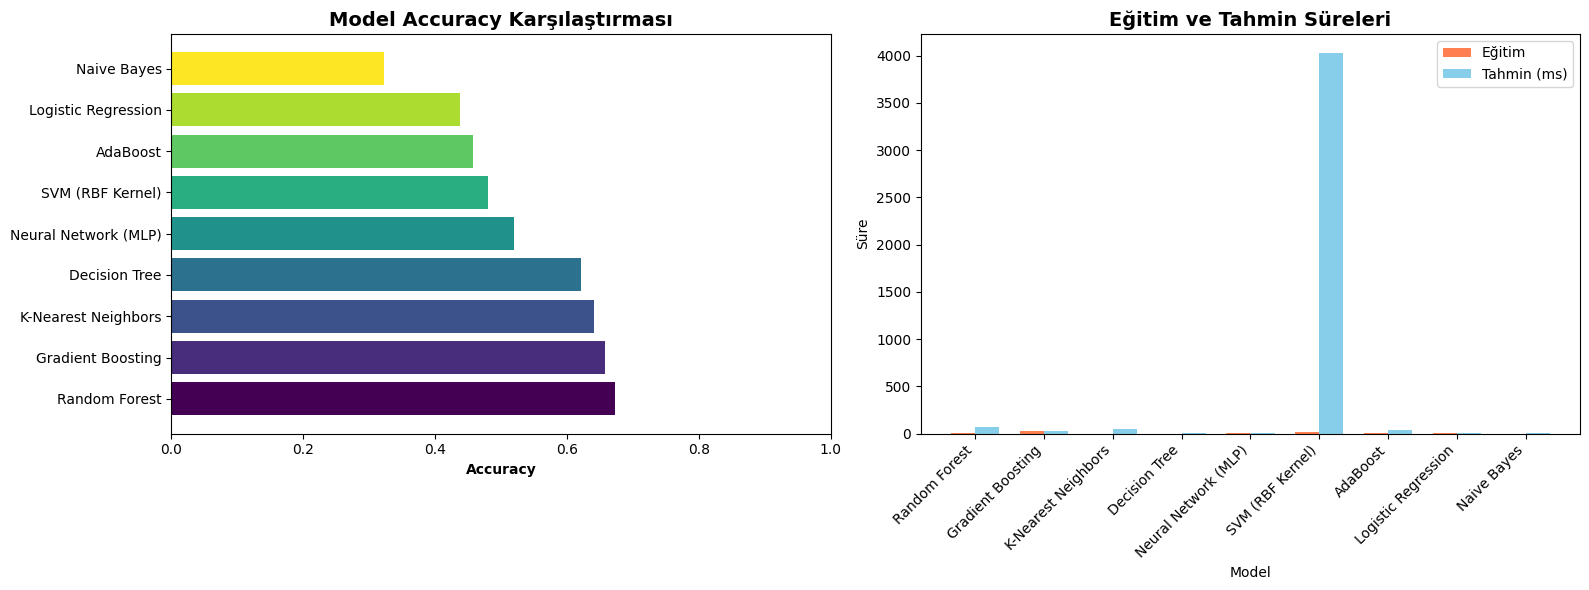


💾 Sonuçlar kaydedildi: model_karsilastirma_sonuclari.csv

 En iyi model kaydedildi: best_model_Random_Forest.pkl
 Scaler kaydedildi: feature_scaler.pkl
 Label Encoder kaydedildi: label_encoder.pkl


In [21]:
# SONUÇLARI KARŞILAŞTIR
if df is not None:
    results = show_comparison()
    
    # En iyi modeli kaydet
    if global_best_model:
        best_name, best_model_obj = global_best_model
        joblib.dump(best_model_obj, f'best_model_{best_name.replace(" ", "_")}.pkl')
        joblib.dump(scaler, 'feature_scaler.pkl')
        joblib.dump(le, 'label_encoder.pkl')
        print(f"\n En iyi model kaydedildi: best_model_{best_name.replace(' ', '_')}.pkl")
        print(f" Scaler kaydedildi: feature_scaler.pkl")
        print(f" Label Encoder kaydedildi: label_encoder.pkl")

In [ ]:
import os
import pandas as pd
import numpy as np
from IPython.display import display, HTML

def predict_test_folder_with_probs(folder_path):
    # Değişkenlerin varlığını kontrol et
    if 'global_best_model' not in globals() or global_best_model is None:
        print(" Hata: Eğitilmiş model bulunamadı.")
        return
    
    # global_best_model = (isim, model_nesnesi)
    model_name, actual_model = global_best_model
    
    test_files = [f for f in os.listdir(folder_path) if f.endswith('.pcap')]
    if not test_files:
        print(" Klasörde .pcap dosyası bulunamadı.")
        return

    results = []
    print(f" Model: {model_name} | Olasılıklar hesaplanıyor...\n")

    for filename in test_files:
        file_path = os.path.join(folder_path, filename)
        flows = process_pcap_file(file_path, label='Tahmin')
        
        if flows:
            df_new = pd.DataFrame(flows)
            X_new = df_new.drop('label', axis=1)
            X_new_scaled = scaler.transform(X_new)
            
            # 1. Sınıf Tahminleri
            preds = actual_model.predict(X_new_scaled)
            
            # 2. Olasılık Tahminleri (Her akış için her kategorinin olasılığı)
            probs = actual_model.predict_proba(X_new_scaled)
            avg_probs = np.mean(probs, axis=0) # Dosyadaki tüm akışların ortalama olasılığı
            
            # En yüksek olasılıklı sınıfın adını al
            predicted_label_idx = pd.Series(preds).mode()[0]
            final_label = le.inverse_transform([predicted_label_idx])[0]
            
            # Olasılıkları kategori isimleriyle eşleştir
            prob_dict = {le.classes_[i]: f"%{avg_probs[i]*100:.2f}" for i in range(len(le.classes_))}
            
            # Sonuçları listeye ekle
            res_entry = {"Dosya": filename, "Baskın Tahmin": final_label}
            res_entry.update(prob_dict) # Kategori olasılıklarını sütun olarak ekle
            results.append(res_entry)
            
            print(f"✅ {filename} işlendi.")

    # Sonuçları tablo olarak bastır
    result_df = pd.DataFrame(results)
    display(HTML("<h3 style='color: #2c3e50;'>📊 Dosya Bazlı Tahmin Olasılıkları</h3>"))
    display(result_df)

# Klasör yolunu r'...' formatında yazmayı unutmayın
predict_test_folder_with_probs(r'C:\Users\tunah\Desktop\Test')

🤖 Model: Random Forest | Olasılıklar hesaplanıyor...

✅ download_deneme.pcap işlendi.
✅ gezinti_deneme.pcap işlendi.
✅ ses_deneme.pcap işlendi.
✅ video_deneme.pcap işlendi.
✅ zoom_deneme.pcap işlendi.


,Dosya,Baskın Tahmin,Download,Gezinti,Ses,Video,Zoom
0,download_deneme.pcap,Ses,%16.34,%23.11,%34.61,%17.95,%8.00
1,gezinti_deneme.pcap,Gezinti,%6.58,%65.42,%11.60,%8.69,%7.71
2,ses_deneme.pcap,Ses,%11.28,%15.87,%43.62,%20.45,%8.77
3,video_deneme.pcap,Ses,%11.79,%13.13,%34.30,%26.09,%14.68
4,zoom_deneme.pcap,Ses,%11.63,%10.89,%31.33,%29.08,%17.07
